In [1]:
!pip install transformers

     |████████████████████████████████| 1.4MB 14.0MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
     |████████████████████████████████| 2.9MB 56.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=43c2966c1b89628844a26f4e4ed5495bccefc96a8c0f9117d977e7adf6a827db
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pickle
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

with open('drive/My Drive/ODQA/dict_idq_q_pp_train16k.pickle',"rb") as train_file:
    train_dictionary = pickle.load(train_file)

with open('drive/My Drive/ODQA/dict_idq_q_pp_val5k.pickle',"rb") as val_file:
    val_dictionary = pickle.load(val_file)

with open('drive/My Drive/ODQA/dict_idq_q_pp_15ktest.pickle',"rb") as test_file:
    test_dictionary = pickle.load(test_file)

Mounted at /content/drive


# Setup GPU

In [3]:
from transformers import BertTokenizer,BertModel,AutoTokenizer
import torch 
from transformers import AdamW
torch.cuda.empty_cache()
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


# Helping functions

In [4]:
def get_token(doc, verbose=False):
  if verbose:
    print("input text: ", doc)
  return tokenizer.encode_plus(
                        doc,                     # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = 200,               # Pad & truncate all sentences.
                        pad_to_max_length=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )

def get_embeddings(model, input_ids, token_type_ids, attention_mask):
  outputs = model(input_ids, 
                  token_type_ids=token_type_ids, 
                  attention_mask=attention_mask,     
                  )
  return torch.nn.functional.normalize(outputs[0][:, 0, :], p=2)

def get_similarity_matrix(model, question, passage):
  len_ = len(question['input_ids'])
  embedded_qs = torch.empty(size=(len_,768))
  embedded_ps = torch.empty(size=(len_,768))
  for i in range(len_):
    embedded_qs[i] = get_embeddings(model, 
                             input_ids=question['input_ids'][i].to(device),
                             token_type_ids=question['token_type_ids'][i].to(device),
                             attention_mask=question['attention_mask'][i].to(device)
                             )
    embedded_ps[i] = get_embeddings(model, 
                            input_ids=passage['input_ids'][i].to(device),
                            token_type_ids=passage['token_type_ids'][i].to(device),
                            attention_mask=passage['attention_mask'][i].to(device)
                            )
  similarity_matrix = torch.matmul(embedded_qs, torch.transpose(embedded_ps, 0, 1)) 
  
  return similarity_matrix

# Load BERT-base-uncased

In [5]:
#init tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Gather training data

In [6]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_question, list_passage):
        'Initialization'
        self.question = list_question
        self.passage = list_passage

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.question)

  def __getitem__(self, index):
        'Generates one sample of data'
        q = self.question[index]
        p = self.passage[index]
        return {'question':q, 'passage': p}

In [7]:
import random

def extract_sample(dictionary, sample_size):
  idxs = list(dictionary.keys()); random.shuffle(idxs);
  question = []
  passage = []
  for idx in idxs[:sample_size]:
    q = get_token(dictionary[idx]['question'])
    p = get_token(dictionary[idx]['pos_passage'])
    question.append(q)
    passage.append(p)
  
  return question, passage

In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size_=8

train_qs, train_ps = extract_sample(train_dictionary, sample_size=14000)
training_dataset = Dataset(train_qs, train_ps)

train_dataloader = DataLoader(
          training_dataset, 
          sampler = RandomSampler(training_dataset),
          batch_size=batch_size_)

val_qs, val_ps = extract_sample(val_dictionary, sample_size=4000)
validation_dataset = Dataset(val_qs, val_ps)

validation_dataloader = DataLoader(
          validation_dataset, 
          sampler = SequentialSampler(validation_dataset),
          batch_size=batch_size_)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Freeze layers before tuning

In [9]:
tune_lst_3layers=True

if tune_lst_3layers==True:
  layers_to_tune = ['9','10','11']
  for name, param in model.named_parameters():
    if not any(layer in name for layer in layers_to_tune):
      param.requires_grad = False

In [10]:
tune_lst_2layers=False

if tune_lst_2layers==True:
  layers_to_tune = ['10','11']
  for name, param in model.named_parameters():
    if not any(layer in name for layer in layers_to_tune):
      param.requires_grad = False

In [11]:
tune_lst_layer=False

if tune_lst_layer==True:
  layers_to_tune = ['11']
  for name, param in model.named_parameters():
    if not any(layer in name for layer in layers_to_tune):
      param.requires_grad = False

In [12]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+----------------------------------------------------+------------+
|                      Modules                       | Parameters |
+----------------------------------------------------+------------+
|    encoder.layer.9.attention.self.query.weight     |   589824   |
|     encoder.layer.9.attention.self.query.bias      |    768     |
|     encoder.layer.9.attention.self.key.weight      |   589824   |
|      encoder.layer.9.attention.self.key.bias       |    768     |
|    encoder.layer.9.attention.self.value.weight     |   589824   |
|     encoder.layer.9.attention.self.value.bias      |    768     |
|   encoder.layer.9.attention.output.dense.weight    |   589824   |
|    encoder.layer.9.attention.output.dense.bias     |    768     |
| encoder.layer.9.attention.output.LayerNorm.weight  |    768     |
|  encoder.layer.9.attention.output.LayerNorm.bias   |    768     |
|     encoder.layer.9.intermediate.dense.weight      |  2359296   |
|      encoder.layer.9.intermediate.dense.bias  

21263616

# Fine-tune model

In [13]:
# Tell pytorch to run this model on the GPU.
model.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [14]:
import time
import datetime
import numpy as np

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
optimizer = AdamW(model.parameters(),lr = 1e-5)
criterion=torch.nn.LogSoftmax(dim=1)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantitites such as training and validation loss,
# validatioon accuracy, and timings

training_stats = []

num_epochs = 3

# Measure the total training time for the whole run.
total_t0 = time.time()

#start train
for epoch_i in range(0, num_epochs):

  # ========================================================================
  #                            Training
  # ========================================================================

  # perform one full pass over the training set.

  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  total_train_loss = 0

  # put the model intro traning mode
  # dropout and batchnorm layers behave differently during training vs test
  # (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
  model.train()

  # for each batch of training data
  for step, training_batch in enumerate(train_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    # Unpack this training batch from our dataloader
    question_train = training_batch['question']
    passage_train = training_batch['passage']

    # Always clear any previously calculated gradients before performing a backward pass.
    # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
    model.zero_grad()

    #perform a forward pass (evaluate the model on this traning batch)
    sim_matrix = get_similarity_matrix(model, question_train, passage_train)
    #print(sim_matrix.size())
    targets = torch.eye(batch_size_)
    loss = torch.sum((criterion(sim_matrix)*-1)*targets, dim=1)

    # Accumalate the traning loss over all of the batches so that we can calculate the average loss at the end
    # losss is a Tensor containing a single value; the .item() returns the Python value from Tensor
    total_train_loss += loss.sum().item()

    # Perform backward pass to calculate the gradients
    loss.sum().backward()
    #loss.mean().backward()

    # clip the norm of the gradients to 1.0
    # This is to help preveent the "exploding gradients" problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule" -- how the parameters are 
    # modified based on their gradients, the learning rate, etc.

    optimizer.step()
    #optimizer.zero_grad()

  # Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for validation_batch in validation_dataloader:
    # Unpack this training batch from our dataloader
    question_val = validation_batch['question']
    passage_val = validation_batch['passage']

    with torch.no_grad():

      #perform a forward pass (evaluate the model on this validation batch)
      sim_matrix = get_similarity_matrix(model, question_val, passage_val)
      targets = torch.eye(batch_size_)
      loss = torch.sum((criterion(sim_matrix)*-1)*targets, dim=1)

    # Accumulate the validation loss
    total_eval_loss += loss.sum().item()

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)
  
  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Training Time': training_time,
          'Validation Time': validation_time
      }
  )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,750.    Elapsed: 0:00:22.
  Batch    80  of  1,750.    Elapsed: 0:00:44.
  Batch   120  of  1,750.    Elapsed: 0:01:06.
  Batch   160  of  1,750.    Elapsed: 0:01:28.
  Batch   200  of  1,750.    Elapsed: 0:01:49.
  Batch   240  of  1,750.    Elapsed: 0:02:11.
  Batch   280  of  1,750.    Elapsed: 0:02:33.
  Batch   320  of  1,750.    Elapsed: 0:02:55.
  Batch   360  of  1,750.    Elapsed: 0:03:17.
  Batch   400  of  1,750.    Elapsed: 0:03:39.
  Batch   440  of  1,750.    Elapsed: 0:04:01.
  Batch   480  of  1,750.    Elapsed: 0:04:22.
  Batch   520  of  1,750.    Elapsed: 0:04:44.
  Batch   560  of  1,750.    Elapsed: 0:05:06.
  Batch   600  of  1,750.    Elapsed: 0:05:28.
  Batch   640  of  1,750.    Elapsed: 0:05:50.
  Batch   680  of  1,750.    Elapsed: 0:06:12.
  Batch   720  of  1,750.    Elapsed: 0:06:33.
  Batch   760  of  1,750.    Elapsed: 0:06:55.
  Batch   800  of  1,750.    Elapsed: 0:07:17.
  Batch   840  of

In [16]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,12.66,11.83,0:15:56,0:03:03
2,12.01,11.68,0:15:55,0:03:02
3,11.86,11.66,0:15:54,0:03:02


In [17]:
 from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+----------------------------------------------------+------------+
|                      Modules                       | Parameters |
+----------------------------------------------------+------------+
|    encoder.layer.9.attention.self.query.weight     |   589824   |
|     encoder.layer.9.attention.self.query.bias      |    768     |
|     encoder.layer.9.attention.self.key.weight      |   589824   |
|      encoder.layer.9.attention.self.key.bias       |    768     |
|    encoder.layer.9.attention.self.value.weight     |   589824   |
|     encoder.layer.9.attention.self.value.bias      |    768     |
|   encoder.layer.9.attention.output.dense.weight    |   589824   |
|    encoder.layer.9.attention.output.dense.bias     |    768     |
| encoder.layer.9.attention.output.LayerNorm.weight  |    768     |
|  encoder.layer.9.attention.output.LayerNorm.bias   |    768     |
|     encoder.layer.9.intermediate.dense.weight      |  2359296   |
|      encoder.layer.9.intermediate.dense.bias  

21263616

### Save model

In [18]:
model_name = "02_norm_batch8"
model.save_pretrained('drive/My Drive/ODQA/Models/'+model_name)

# Test results

In [ ]:
@torch.no_grad()
def get_test_matrix(model, question, passage):
  len_ = len(question)
  embedded_qs = torch.empty(size=(len_,768))
  embedded_ps = torch.empty(size=(len_,768))
  for i in range(len_):
    embedded_qs[i] = get_embeddings(model, 
                             input_ids=question[i]['input_ids'],
                             token_type_ids=question[i]['token_type_ids'],
                             attention_mask=question[i]['attention_mask']
                             )
    embedded_ps[i] = get_embeddings(model, 
                            input_ids=passage[i]['input_ids'],
                            token_type_ids=passage[i]['token_type_ids'],
                            attention_mask=passage[i]['attention_mask']
                            )
  print("calculating the similarity matrix")
  similarity_matrix = torch.matmul(embedded_qs, torch.transpose(embedded_ps, 0, 1)) 
  
  return similarity_matrix

In [ ]:
import matplotlib.pyplot as plt  # This is python's popular plotting library.
# This is to ensure matplotlib plots inline and does not try to open a new window.
%matplotlib inline 

def showTensor(aTensor):
    plt.figure()
    plt.imshow(aTensor.numpy())
    plt.colorbar()
    plt.show()

In [ ]:
def acc_from_matrix(sim_mat,n):
  counter=0
  acc=0
  for line in sim_mat:
    ind = np.argpartition(line, -n)[-n:]
    if counter in ind:
      acc+=1
    counter+=1
  return acc/counter

## Extract test data

In [ ]:
qs_test, ps_test = extract_sample(test_dictionary, sample_size=200)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### TF-IDF

In [ ]:
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

class TFidf:
    def tfidf_vectors(self, corpus):    
        vectorizer = TfidfVectorizer()
        vectors = vectorizer.fit_transform(corpus)
        feature_names = vectorizer.get_feature_names()
        dense = vectors.todense()
        denselist = dense.tolist()
    
        return pd.DataFrame(denselist, columns=feature_names)

    def tfidf_embedding(self, corpus):
        embeddings = []  

        df = self.tfidf_vectors(corpus)

        for _, row in df.iterrows():
            embeddings.append(np.array(row))

        sim_to_quest = []
        for _, emb_i in enumerate(embeddings[1:]):
            sim_to_quest.append(np.dot(emb_i, embeddings[0]))
        
        return sim_to_quest

In [ ]:
passages = [dictionary[i]['pos_passage'] for i in idxs_test]
questions = [dictionary[i]['question'] for i in idxs_test]
sim_matrix = []
tf=TFidf()
for i in range(len(idxs_test)):
  corpus =  list(itertools.chain(*[[questions[i]],passages]))
  sim_matrix.append(tf.tfidf_embedding(corpus))

### BERT - Init

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

calculating the similarity matrix


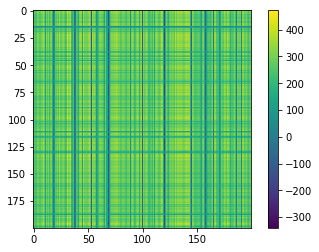

In [ ]:
sim_matrix = get_test_matrix(bert_model, qs_test, ps_test)
showTensor(sim_matrix)

### BERT - Full fine-tuning

In [ ]:
loaded_model = BertModel.from_pretrained('drive/My Drive/ODQA/Models/RetrBERT_Last3_norm')

calculating the similarity matrix


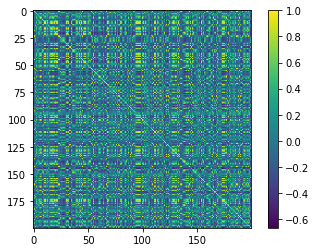

In [ ]:
sim_matrix = get_test_matrix(loaded_model, qs_test, ps_test)
showTensor(sim_matrix)

### BERT - 2 Layer fine-tuning

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
lst2_layer_model = BertModel.from_pretrained('drive/My Drive/ODQA/Models/BERT_2lst_10000s_50b')

calculating the similarity matrix


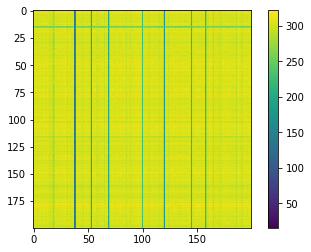

In [ ]:
sim_matrix = get_test_matrix(lst2_layer_model, qs_test, ps_test)
showTensor(sim_matrix)

In [ ]:
acc_from_matrix(sim_matrix,1)

0.1

In [ ]:
acc_from_matrix(sim_matrix,2)

0.824

In [ ]:
acc_from_matrix(sim_matrix,3)

0.879

In [ ]:
acc_from_matrix(sim_matrix,4)

0.908

In [ ]:
acc_from_matrix(sim_matrix,5)

0.932

In [ ]:
acc_from_matrix(sim_matrix,10)

0.985

In [ ]:
acc_from_matrix(sim_matrix,15)

0.993